# Imports

In [214]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, CuDNNLSTM
import numpy as np
import matplotlib.pyplot as plt
import copy

# Global Variables

In [215]:
MAX_INITIAL_POSITION = 0.1
MAX_INITIAL_VELOCITY = 0.1
MAX_INITIAL_ACCELERATION = 0.1
TIME_STEPS = 30
SAMPLE_SIZE = 10000
EPOCHS = 20
DT = 0.1

# Classes

In [216]:
class Particle:
    def __str__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __repr__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __init__(self):
        self.position = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * MAX_INITIAL_POSITION # Position X, Y
        self.velocity = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * MAX_INITIAL_VELOCITY # Velocity X, Y
        self.acceleration = np.array([0,0]) # np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * MAX_INITIAL_ACCELERATION # Acceleration X, Y
        
    def apply_physics(self,dt):
        nextParticle = copy.deepcopy(self) # Copy to retain initial values
        nextParticle.position += self.velocity * dt
        nextParticle.velocity += self.acceleration * dt
        return nextParticle
    
    def apply_random_acceleration(self):
        self.acceleration = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * MAX_INITIAL_ACCELERATION # Acceleration X, Y
        
    def apply_harmonic_acceleration(self, time):
        self.acceleration = np.array([np.cos(time), np.sin(time)]) * MAX_INITIAL_ACCELERATION
    
    def as_list(self):
        return [self.position[0],self.position[1],self.velocity[0], self.velocity[1]], [self.acceleration[0], self.acceleration[1]]
    
    def physics_as_list(self,dt):
        n = self.apply_physics(dt)
        return [n.position[0], n.position[1], n.velocity[0], n.velocity[1]]

In [217]:
class RNN:
    def __str__(self):
        self.model.summary()
        return ""
    
    def __repr__(self):
        self.model.summary()
        return ""
    
    def __init__(self, input_size, time_steps, output_size, dropout=0.4):
        self.model = self.generate_model(input_size, output_size, time_steps, dropout)
        
    def generate_model(self, input_size, output_size, time_steps, dropout):
        initial_parameters = Input((1,input_size[0]))
        applied_parameters = Input((time_steps,input_size[1]))
        
        _, state_h, state_c = CuDNNLSTM(64, return_state=True)(applied_parameters)
        
        states = [state_h, state_c]
        
        lstm_output = CuDNNLSTM(64)(initial_parameters, initial_state=states)
        
        output_layer = Dense(output_size*time_steps, activation='tanh')(lstm_output)
        
        model = Model([initial_parameters,applied_parameters], output_layer)
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model
    def train(self, input_data, output_data, batch_size=32, epochs=10):
        self.model.fit(input_data, output_data, batch_size=batch_size, epochs=epochs)
    def predict(self,input_data):
        return self.model.predict(input_data)

# Training Data

In [218]:
def get_samples(dt, sample_size, time_steps):
    objects = []
    applied = []
    steps = []
    for _ in range(sample_size):
        particle = Particle()
        obj, _ = particle.as_list()
        apply = []
        step = []
        objects.append(obj)
        for t in range(time_steps):
            particle.apply_harmonic_acceleration(t*dt)
            _, app = particle.as_list()
            apply.append(app)
            step.append(particle.physics_as_list(dt))
            particle = particle.apply_physics(dt)
        steps.append(step)
        applied.append(apply)
    return np.array(objects).reshape(-1,1,4), np.array(applied).reshape(-1,time_steps,2), np.array(steps).reshape(-1,time_steps*4)

# Training

In [219]:
rnn = RNN(input_size=[4,2], output_size=4, time_steps=TIME_STEPS)
objects, applied, steps = get_samples(dt=DT, sample_size=SAMPLE_SIZE, time_steps=TIME_STEPS)
rnn.train([objects, applied], steps, epochs=EPOCHS)

Epoch 1/20
10000/10000 [==============================] - 8s 836us/step - loss: 0.0063 - acc: 0.4994
Epoch 2/20
10000/10000 [==============================] - 6s 636us/step - loss: 1.1205e-04 - acc: 0.8001
Epoch 3/20
10000/10000 [==============================] - 6s 640us/step - loss: 8.9439e-06 - acc: 0.9747
Epoch 4/20
10000/10000 [==============================] - 6s 627us/step - loss: 8.5442e-06 - acc: 0.9841
Epoch 5/20
10000/10000 [==============================] - 6s 627us/step - loss: 7.6148e-06 - acc: 0.9855
Epoch 6/20
10000/10000 [==============================] - 6s 643us/step - loss: 7.9311e-06 - acc: 0.9856
Epoch 7/20
10000/10000 [==============================] - 6s 632us/step - loss: 6.7542e-06 - acc: 0.9857 0s - loss: 6.7523e-06 - acc: 0.9
Epoch 8/20
10000/10000 [==============================] - 6s 631us/step - loss: 7.3729e-06 - acc: 0.9840 0s - loss: 7.4889e-06 -
Epoch 9/20
10000/10000 [==============================] - 7s 656us/step - loss: 6.6941e-06 - acc: 0.9848
Ep

In [220]:
# Shouldn't be using training data for predictions... Too lazy...
predictions = rnn.predict([np.array(objects[:10]).reshape(-1,1,4), np.array(applied[:10]).reshape(-1,TIME_STEPS,2)]).reshape(-1,TIME_STEPS,4)

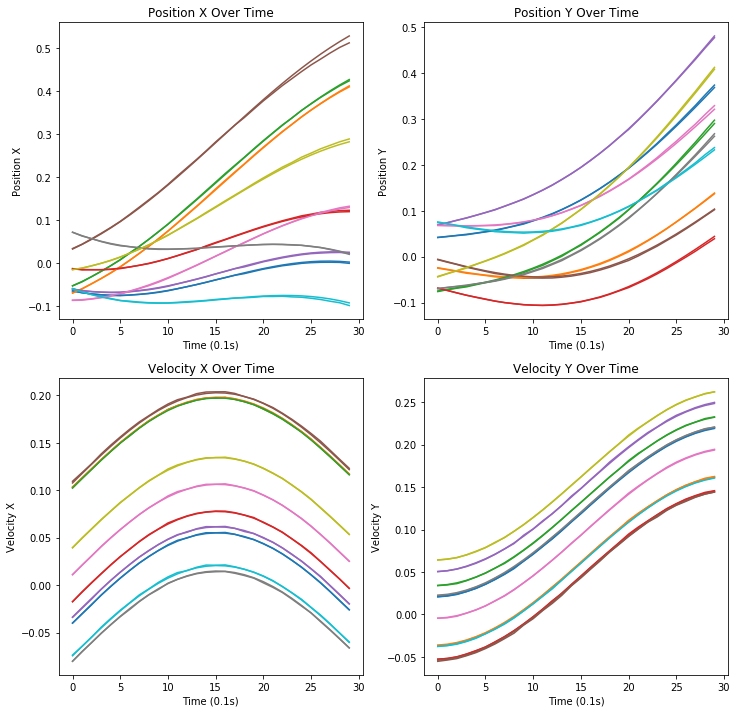

In [224]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.title("Position X Over Time")
plt.xlabel("Time (0.1s)")
plt.ylabel("Position X")
for pred in predictions:
    plt.plot([p[0] for p in pred])
for step in steps.reshape(-1,TIME_STEPS,4)[:10]:
    plt.plot([p[0] for p in step])

plt.subplot(2,2,2)
plt.title("Position Y Over Time")
plt.xlabel("Time (0.1s)")
plt.ylabel("Position Y")
for pred in predictions:
    plt.plot([p[1] for p in pred])
for step in steps.reshape(-1,TIME_STEPS,4)[:10]:
    plt.plot([p[1] for p in step])
    
plt.subplot(2,2,3)
plt.title("Velocity X Over Time")
plt.xlabel("Time (0.1s)")
plt.ylabel("Velocity X")
for pred in predictions:
    plt.plot([p[2] for p in pred])
for step in steps.reshape(-1,TIME_STEPS,4)[:10]:
    plt.plot([p[2] for p in step])
    
plt.subplot(2,2,4)
plt.title("Velocity Y Over Time")
plt.xlabel("Time (0.1s)")
plt.ylabel("Velocity Y")
for pred in predictions:
    plt.plot([p[3] for p in pred])
for step in steps.reshape(-1,TIME_STEPS,4)[:10]:
    plt.plot([p[3] for p in step])

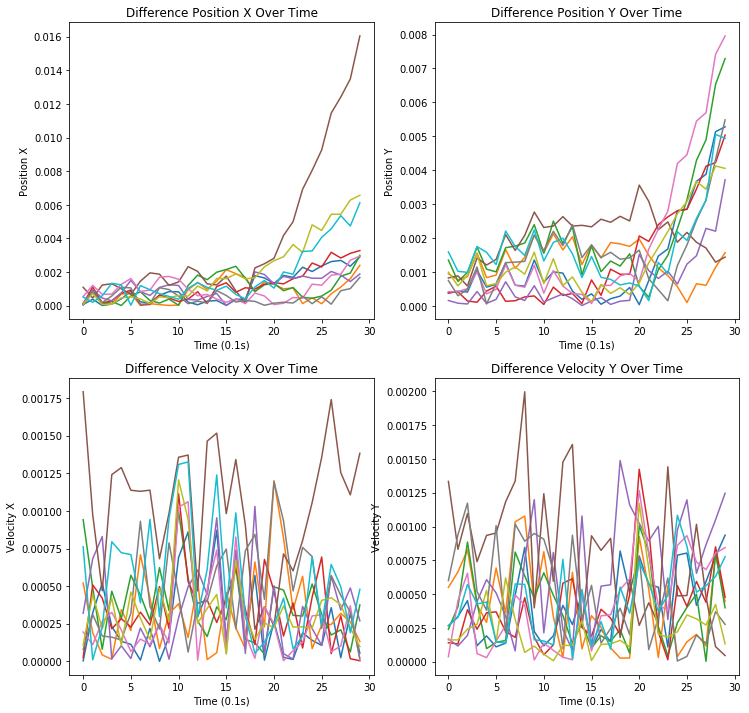

In [226]:
plt.figure(figsize=(12,12))

difference = abs(predictions - steps.reshape(-1,TIME_STEPS,4)[:10])

plt.subplot(2,2,1)
plt.title("Difference Position X Over Time")
plt.xlabel("Time (0.1s)")
plt.ylabel("Position X")
for pred in difference:
    plt.plot([p[0] for p in pred])

plt.subplot(2,2,2)
plt.title("Difference Position Y Over Time")
plt.xlabel("Time (0.1s)")
plt.ylabel("Position Y")
for pred in difference:
    plt.plot([p[1] for p in pred])
    
plt.subplot(2,2,3)
plt.title("Difference Velocity X Over Time")
plt.xlabel("Time (0.1s)")
plt.ylabel("Velocity X")
for pred in difference:
    plt.plot([p[2] for p in pred])
    
plt.subplot(2,2,4)
plt.title("Difference Velocity Y Over Time")
plt.xlabel("Time (0.1s)")
plt.ylabel("Velocity Y")
for pred in difference:
    plt.plot([p[3] for p in pred])